In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import os
import sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, match_coord, bgsmask

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Load GAMA DR4

In [2]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

#get rid of stars in GAMA
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

#
gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA


fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.07 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.93 %


# Load DR9 SWEEPS for GAMA footprint only (G12, G15, G09)

In [3]:
#
def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]

# load catalogue
# this is dr8 sweeps in decals with BGSBITS 


dr = 'dr9-south'
#dir where we are going to stored the results
pathdir = '/global/homes/q/qmxp55/DESI/bgstargets/doc/gama_%s' %(dr)
#if results dir does not exist, create it
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
#get sweeps for GAMA footprint
lsin12 =  get_sweep_whole(patch=gama12(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
lsin15 =  get_sweep_whole(patch=gama15(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
lsin09 =  get_sweep_whole(patch=gama09(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')

# merge the SWEEPS in GAMA fileds targets in a single data frame
cat = np.concatenate((lsin12, lsin15, lsin09))


sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_174.0_186.0_-3.0_2.0.npy
Total run time: 0.016313 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.001628 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_129.0_141.0_-2.0_3.0.npy
Total run time: 0.001351 sec


In [8]:
df = fitsio.read('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-000m015-010m010.fits',
                    columns=None, upper=True, ext=1)

In [ ]:
#
lsin09_all =  get_sweep_whole(patch=gama09(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=False, opt='2', sweepdir='/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/alice/', cols='all')


Progress...N/A%|                                                    |

--------- OPTION 2 ---------
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-120m005-130p000.fits
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-120p000-130p005.fits
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-130m005-140p000.fits
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-130p000-140p005.fits
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-140m005-150p000.fits
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-140p000-150p005.fits
Total bricks found: 	 6


Progress...100%|####################################################|

Total run time: 68.414217 sec
/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/alice/dr9-south_sweep_129.0_141.0_-2.0_3.0


# Match catalogues

In [5]:
#
def match(gama=None, cat=None):
    
    # matching LS8 with gama stars and galaxies
    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    # LS DR8 matched with gama
    dr8_gama = np.zeros_like(cat['RA'], dtype='?') #dr8 that match with gama
    dr8_z = np.full_like(cat['RA'], -1) #z from gama

    dr8_gama[idx2.tolist()] = True
    dr8_z[idx2.tolist()] = gama['Z'][idx1]
    
    return dr8_gama, dr8_z


In [6]:
#
dr8_gama, dr8_z = match(gama, cat)
#get BGS targets
bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #| (L2) #adding the LSLGA galaxies
print('fraction of bgs in %s within GAMA: %i / %i' %(dr, np.sum(bgs), len(cat)))


Doubly matched objects = 1
Final matched objects = 182259
fraction of bgs in dr9-south within GAMA: 262743 / 15862364


mean: 	 0.2246 (all) 	 0.2161 (bright) 	 0.2639 (faint)


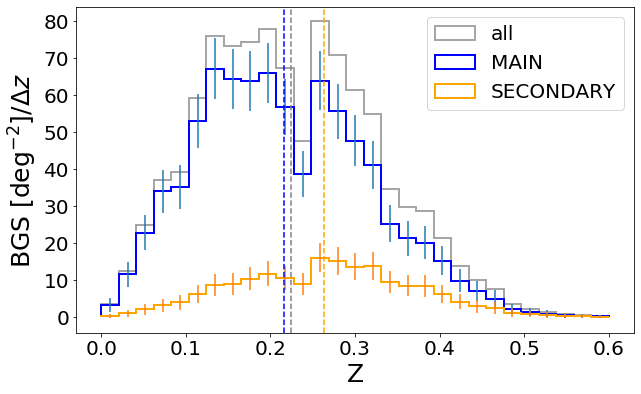

In [7]:
#
fig = plt.figure(figsize=(10,6))

N = np.sum((dr8_gama) & (bgs))
cumu = False
Ared = 175

mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (bgs)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] < 19.5) & (bgs)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.) & (bgs)
bins = np.linspace(0,0.6,30)

#plt.title(r'BGS cross-matched with GAMA DR3', size=18)
h,e,p = plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
hB,eB,pB = plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='blue', label='MAIN')
hF,eF,pF = plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='orange', label='SECONDARY')

#
plt.errorbar((eB[1:]+eB[:-1])/2., hB, np.sqrt(hB), fmt='none')
plt.errorbar((eF[1:]+eF[:-1])/2., hF, np.sqrt(hF), fmt='none')

print('mean: \t %.4f (all) \t %.4f (bright) \t %.4f (faint)' %(
    np.mean(dr8_z[mask]), np.mean(dr8_z[maskB]), np.mean(dr8_z[maskF])
    ))
plt.axvline(np.mean(dr8_z[mask]), ls='--', c='gray')
plt.axvline(np.mean(dr8_z[maskB]), ls='--', c='blue')
plt.axvline(np.mean(dr8_z[maskF]), ls='--', c='orange')

#plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
#plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=25)
plt.ylabel(r'BGS [deg$^{-2}$]/$\Delta z$', size=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

file = pathdir+'bgs_nz'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


#

In [8]:
#get rid of objects within BS, NOBS and GC in GAMA

idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                            gama['RA'], gama['DEC'], search_radius=1)

mask = np.ones_like(cat, dtype=bool)
for i in ['BS', 'nobs', 'GC']:
    mask &= ((cat['BGSBITS'] & 2**(bgsmask()[i])) != 0)
    mask &= (cat['RMAG'] < 20)

gama_mask = np.ones_like(gama['RA'], dtype='?')
gama_mask[idx1.tolist()] = mask[idx2]

print('ratio of gama targets after / before these geometrical masks: \t %i / %i' %(np.sum(gama_mask), len(gama)))


Doubly matched objects = 1
Final matched objects = 182259
ratio of gama targets after / before these geometrical masks: 	 179822 / 182540


In [17]:
#
from io_ import match_gama, gama_assess
from cuts import bgsbut

def gama_assess_plot(cats=None, gamas=None, savefile=None):
    
    fig = plt.figure(figsize=(20, 6))
    ls = ['-', '--', ':']
    area = 60 * 3
    
    for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    
        ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
        gamagal = (ls_z > 0.002)
        val = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)
        
        print('======================= RESULTS %s =======================' %(key))

        print('Total BGS: \t %.3f /deg^2' %(np.sum(val)/area))
        print('GAMA & LS: \t %.2f /deg^2'%(np.sum(ls_gama)/area))
        print('\t GAMA & LS & BGS : \t %.3f /deg^2' % (np.sum(val & ls_gama)/area))
        print('\t GAMA & LS & not in BGS : \t %.3f /deg^2' % (np.sum(~val & ls_gama)/area))
        tot = np.sum(~val & ls_gama)
        print('\t \t & rmag > 20 : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] > 20))/tot))
        print('\t \t & rmag < 20 (rej by a BGS cut) : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] < 20))/tot))

        rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=False)
        rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=True)


        plt.subplot(1, 2, 1)
        plt.plot(rmagl, Ncomp/Ngama_ls, c='k', ls=ls[num], label='bins-%s' %(key))
        plt.plot(rmagl_c, Ncomp_c/Ngama_ls_c, c='r', ls=ls[num], label='cumu-%s' %(key))
        plt.legend(fontsize=20)
        
        if num == 0:
            plt.title(r'completeness', size=22)
            #plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
            plt.axvspan(19.0, 20.0, alpha=0.3, color='red')
            plt.axhline(1, ls='--', c='k')
            #plt.axvline(19.2, ls=':', label='19.2', color='k')
            plt.axvline(19.0, ls=':', label='19.0', color='k')
            plt.xlabel(r'$r_{mag}$', size=22)
            plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=18)
            plt.ylim(0.95, 1.01)
            plt.xlim(14, 20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.grid()


        plt.subplot(1, 2, 2)
        plt.plot(rmagl, Ncont/Ngama_ls, c='k', ls=ls[num], label='bins-%s' %(key))
        plt.plot(rmagl_c, Ncont_c/Ngama_ls_c, c='r', ls=ls[num], label='cumu-%s' %(key))
        plt.legend(fontsize=20)
        
        if num == 0:
            plt.title(r'contamination', size=22)
            #plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
            plt.axvspan(19.0, 20.0, alpha=0.3, color='red')
            plt.axhline(1, ls='--', c='k')
            #plt.axvline(19.2, ls=':', label='19.2', color='k')
            plt.axvspan(19.0, 20.0, alpha=0.3, color='red')
            plt.xlabel(r'$r_{mag}$', size=22)
            plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=18)
            plt.ylim(0, 1.5)
            plt.xlim(14, 20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.grid()

    if savefile is not None:
        fig.savefig(savefile+'.png', bbox_inches = 'tight', pad_inches = 0)


In [18]:
os.path.join(pathdir, 'gama_assess_comp_cont')

'/global/homes/q/qmxp55/DESI/bgstargets/doc/gama_dr9-south/gama_assess_comp_cont'

Doubly matched objects = 1
Final matched objects = 179541
======================= RESULTS dr9 =======================
Total BGS: 	 1467.783 /deg^2
GAMA & LS: 	 997.45 /deg^2
	 GAMA & LS & BGS : 	 988.500 /deg^2
	 GAMA & LS & not in BGS : 	 8.950 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %


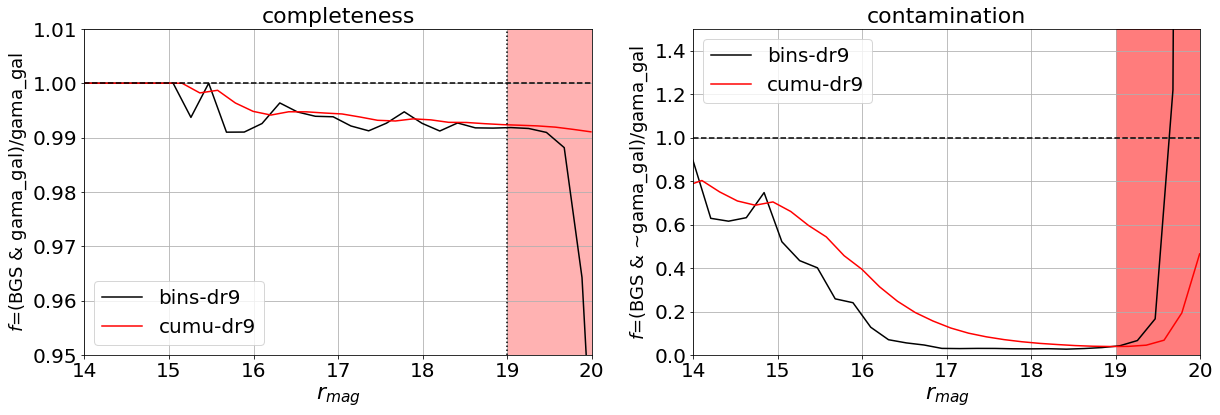

In [19]:
gama_assess_plot(cats={'dr9':cat}, gamas={'gama':gama[gama_mask]}, savefile=os.path.join(pathdir, 'gama_assess_comp_cont'))

In [23]:
def get_bars_gama(labels=None, cats=None, gamas=None, bgsmask=None, log=False, width=None, figsize=(30,10), title=None):
        
    #labels = ['BS', 'MS', 'LG', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    rects = {}

    x = np.arange(len(labels))  # the label locations
    if width is None: width = 0.3  # the width of the bars
    delta = 0

    fig, ax = plt.subplots(figsize=figsize)
    
    rejs_all = {}

    for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    
        ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
        gamagal = (ls_z > 0.002)
        
        rejs = []
        for i in labels:
            bgsbut_ = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask, rlimit=20)
            rej = ((cat['BGSBITS'] & 2**(bgsmask[i])) != 0)
            pb = (bgsbut_) & (~rej)
            rejs.append(np.sum((ls_gama) & (pb))/np.sum(pb))
            
            rejs_all['pb_%s_%s' %(key, i)] = pb
            rejs_all['pbgama_%s_%s' %(key, i)] = (~ls_gama) & (pb)
            
        #val = [np.sum((bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask(), rlimit=20)) & ~((cat['BGSBITS'] & 2**(bgsmask[i])) != 0) & ()) for i in labels]
        
        rects[key] = ax.bar(x - 1*width + delta, rejs, width, label=key)
        delta += width

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('gama & PB / PB', size=30)
    if title is not None: ax.set_title(title, size=30)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30, rotation=45)
    ax.legend(fontsize=15)
    if log: ax.set_yscale('log')

    for i in rects.keys():
        #autolabel(i)
        #print(i)
        #autolabel(rects[i])
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects[i]:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(3, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()

    plt.show()
    
    return rejs_all

Doubly matched objects = 1
Final matched objects = 179541


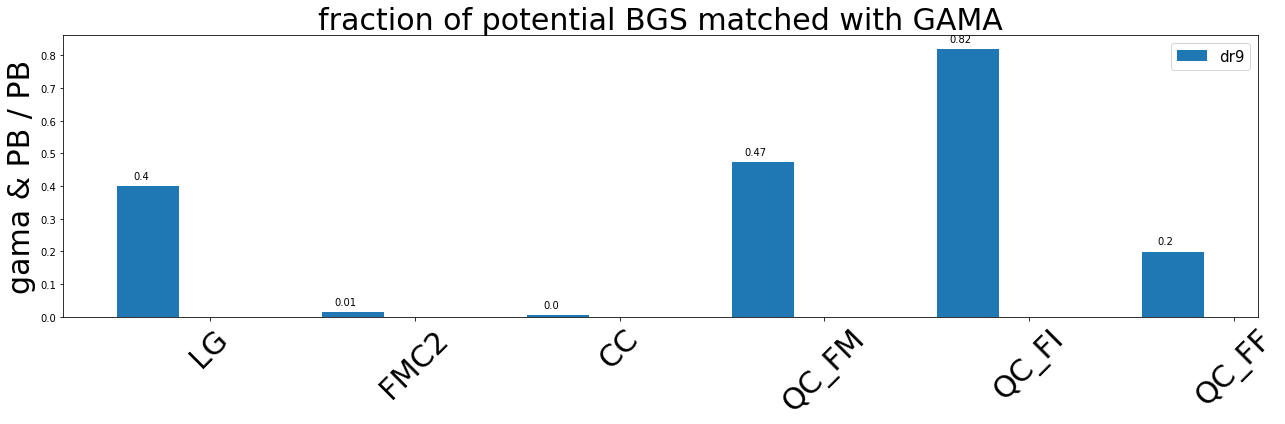

In [24]:
#
labels = ['LG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
rejs_all = get_bars_gama(labels=labels, cats={'dr9':cat}, gamas={'gama':gama[gama_mask]}, bgsmask=bgsmask(), title='fraction of potential BGS matched with GAMA', figsize=(18,6))